# Reproduction of Geography 120 Gerrymandering and Area-Weighted Reaggregation Lab

### Authors

Grace Sokolow\*, gsokolow@middlebury.edu, @gsokolow, Middlebury College (Undergraduate)

\* Corresponding author and creator


Version 0.1.0 \| First Created November 30, 2023 \| Updated November 30, 2023



### NOTE

can delete any extraneous bits and then bring in all the analysis plan info via code or copy and paste; see the original template format for what's suggested

use markdown (here()) -> ask Liam
** things to fix if time **
- add spatial index to make union faster
- fix planar area to geodesic in the non-compactness instances -> generates same results; something interesting to consider in discussion
- add also in discussion that you cant actually have half a person or vote in a district

## Abstract

This study is a *replication* of:

> Kimambo, Niwaeli. 2021. *Lec/Lab: Gerrymandering: Maps and political representation* Human Geography with GIS (GEOG 120) at Middlebury College.

The original lab aims to determine whether North Carolina's 2019 congressional districts, which were redrawn by court order, are fairer than the 2016 districts based on geographic compactness and political representation.
First, votes cast in the 2016 presidential election are used to estimate the percentage of Republican voters in the 2016 and 2019 congressional districts.
Then, compactness scores are calculated by multiplying the area by 400π and dividing by the perimeter squared.
The deliverables include summary statistics for the compactness and percentage of Republicans from the 2026 and 2019 districts, as well as 4 maps: 
percentage votes for Republican presidential candidate by voting precinct, percentage votes for the 2016 Republican presidential candidate by 2016 districts, percentage of votes for the 2016 Republican presidential candidate by 2019 districts, and the compactness scores for each 2016 and 2019 district.

This replication shifts the computational environment from QGIS to Python. Several data layers are provided for the original lab, including the 2016 and 2019 congressional district maps and the 2016 North Carolina voting precints and presidential election data. This study uses the originally given data layers. A next step for a reanalysis of this study would be to pull in the data directly from the original sources, but this is outside the scope of this replication study.

## Study design

This study is a **reproduction** of Kimambo's 2021 lab. No changes are planned to the mothodology of the original lab; only the computational environment is different.

Kimambo's original lab is an observational study of partisan gerrymandering in North Carolina. It aims to determine if the court-ordered redistricting of North Carolina's 2016 districts resulted in districts that were more fair in terms of geographic compactness and political representation. An area weighted reaggregation is used to allocate votes for the Republican presidential candidate in 2016 to North Carolina's 2016 and 2019 congressonal districts. To calculate compactness for each district, the following equation is used: compactness = 400 * π * area / perimeter^2.

## Computational environment

This study uses Python 3.11.5. Dependencies are linked in procedure/environment/requirements.txt


In [1]:
# report python version and install required packages
# switch if statement from True to False once packages have been installed
if True:
    !python -V
    !pip install -r ../environment/requirements.txt

Python 3.11.5
Defaulting to user installation because normal site-packages is not writeable

ERROR: Could not find a version that satisfies the requirement geodatsets (from versions: none)
ERROR: No matching distribution found for geodatsets


In [ ]:
pip install geodatasets

In [ ]:
pip install shapely

In [ ]:
pip install geopandas

In [2]:
# Now, let's import what we need
import geopandas as gpd
import pandas as pd
import geodatasets as gds
from shapely.validation import make_valid
import math


C:\ProgramData\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [ ]:
# check version
pip.freeze

### Read in Data Sources

Let's open each data source and examine its variables.

In [3]:
cd_2016 = gpd.read_file("../../data/raw/public/givens/2016_Contingent_Congressional_Plan_Corrected.shp")
cd_2019 = gpd.read_file("../../data/raw/public/givens/C-Goodwin-A-1-TC.shp")
pc2016 = gpd.read_file("../../data/raw/public/givens/precincts.shp")

print(pc2016.head(0))

Empty GeoDataFrame
Columns: [PREC_ID, ENR_DESC, COUNTY_NAM, COUNTY_ID, dem, rep, cntyprec, geometry]
Index: []


In [ ]:
pc2016.dtypes

In [ ]:
pc2016["rep"].min()

### Pre-process precincts.shp
Reproject precincts to CRS: 32119 NAD 1983 North Carolina to match district projection.

In [4]:
precincts_nad = pc2016.to_crs("32119")

In [5]:
precincts_nad.head()

,PREC_ID,ENR_DESC,COUNTY_NAM,COUNTY_ID,dem,rep,cntyprec,geometry
0,06N,06N_NORTH GRAHAM,ALAMANCE,1,834,423,ALAMANCE 06N,"POLYGON ((574414.625 259454.303, 574565.642 25..."
1,1210,1210_BURLINGTON 10,ALAMANCE,1,607,569,ALAMANCE 1210,"POLYGON ((569091.687 256911.578, 568506.748 25..."
2,06E,06E_EAST GRAHAM,ALAMANCE,1,741,671,ALAMANCE 06E,"POLYGON ((574700.886 258104.143, 574717.887 25..."
3,063,063_GRAHAM 3,ALAMANCE,1,996,528,ALAMANCE 063,"POLYGON ((574565.642 259472.906, 574414.625 25..."
4,12N,12N_NORTH BURLINGTON,ALAMANCE,1,1777,289,ALAMANCE 12N,"POLYGON ((570637.807 260328.792, 570632.385 26..."


This is a slight deviation from the pre-analysis plan. In my original work with this lab in 2021, there were invalid geometries in QGIS that needed to be fixed. However, the code below demonstrates that there are no invalid geometries in this dataset, so we will move right along!

In [6]:
precincts_nad.length

0       10375.878040
1        8567.909030
2       14576.665524
3       13994.354802
4       11922.231568
            ...     
2699     3178.844456
2700    33045.757952
2701    11930.595654
2702    17679.353613
2703    14161.782324
Length: 2704, dtype: float64

In [7]:
precincts_fix = precincts_nad.is_valid

precincts_fix[precincts_fix  == 'False'].index.tolist() 

[]

Now, let's calculate precinct area and percentage of republican votes cast in the precinct. We need to use precincts_nad and not precincts_fix because precincts_fix is a list of whether or not the precincts are valid.

**Unplanned deviation in analysis:** All gometric operations in geopandas are planar: ie based off whatever 2D projection is in use. However, to calculate this instance of area, geodesic measurement is preferred, which requires the use of ArcPy. There does appear to be a method of switching between ArcPy objects and geopandas dataframes, but for now, proceed with the planar area calculation. This applies to both pArea (calculated here) and fArea (calculated below).

In [8]:
precincts_nad = precincts_nad.assign(pArea = precincts_nad.geometry.area)

In [9]:
precincts_nad = precincts_nad.assign(pctRep = precincts_nad['rep']/(precincts_nad['rep']+precincts_nad['dem']))

### Conduct Area-Weighted Reaggregation in 2016 Districts
First, perform a union between the precincts (with the new fields) and the 2016 congressional districts. In making the union, there is a warning about dropping non-matching geometry types. Based on a visual check of the resulting file, no holes have been created by dropping these non-polygon geometries and thus the warning can be disregarded.

**Deviation from analysis plan:** This union takes a long time to run, so export as Union_2016_precincts_2016_districts.shp and read back in


In [10]:
precincts_nad.geom_type.unique ()

array(['Polygon', 'MultiPolygon'], dtype=object)

In [11]:
## this code block runs and saves a union between the 2016 precinct fragments and the 2016 congressional districts. It takes ~10 minutes to run and has thus been commented out for efficiency. One way to make it faster might be to use a spatial index. It gets read back in from the data folder below.
#frag_2016 = precincts_nad.overlay(cd_2016, how='union')

## save and reimport file to avoid long run times
#frag_2016.to_file("../../data/derived/public/Union_2016_precinct_2016_district.shp")

In [12]:
frag_2016 = gpd.read_file("../../data/derived/public/Union_2016_precinct_2016_district.shp")

<Axes: >

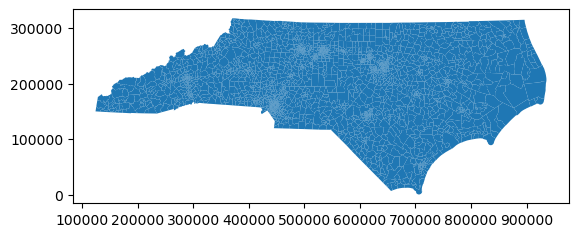

In [14]:
frag_2016.plot()

In [15]:
frag_2016.head(30)

,PREC_ID,ENR_DESC,COUNTY_NAM,COUNTY_ID,dem,rep,cntyprec,pArea,pctRep,District,geometry
0,06N,06N_NORTH GRAHAM,ALAMANCE,1.0,834.0,423.0,ALAMANCE 06N,4.295296e+06,0.336516,6.0,"POLYGON ((574565.642 259472.906, 574566.725 25..."
1,1210,1210_BURLINGTON 10,ALAMANCE,1.0,607.0,569.0,ALAMANCE 1210,3.105714e+06,0.483844,6.0,"POLYGON ((568506.748 256892.610, 568492.331 25..."
2,06E,06E_EAST GRAHAM,ALAMANCE,1.0,741.0,671.0,ALAMANCE 06E,6.182702e+06,0.475212,6.0,"POLYGON ((574717.887 258121.275, 574748.910 25..."
3,063,063_GRAHAM 3,ALAMANCE,1.0,996.0,528.0,ALAMANCE 063,5.727881e+06,0.346457,6.0,"POLYGON ((574414.625 259454.303, 574195.021 25..."
4,12N,12N_NORTH BURLINGTON,ALAMANCE,1.0,1777.0,289.0,ALAMANCE 12N,7.176965e+06,0.139884,6.0,"POLYGON ((570632.385 260324.377, 570550.593 26..."
5,125,125_BURLINGTON 5,ALAMANCE,1.0,523.0,874.0,ALAMANCE 125,3.348526e+06,0.625626,6.0,"POLYGON ((568004.051 258866.895, 568014.141 25..."
6,11,11_PLEASANT GROVE,ALAMANCE,1.0,1142.0,1037.0,ALAMANCE 11,1.158797e+08,0.475906,6.0,"POLYGON ((585798.707 276715.689, 585959.227 27..."
7,10S,10S_SOUTH MELVILLE,ALAMANCE,1.0,2445.0,2240.0,ALAMANCE 10S,2.237237e+07,0.478122,6.0,"POLYGON ((585059.668 260448.555, 585191.909 26..."
8,064,064_GRAHAM 4,ALAMANCE,1.0,1054.0,1800.0,ALAMANCE 064,1.701353e+07,0.630694,6.0,"POLYGON ((573910.256 252472.400, 573886.007 25..."
9,128,128_BURLINGTON 8,ALAMANCE,1.0,788.0,325.0,ALAMANCE 128,3.313180e+06,0.292004,6.0,"POLYGON ((568441.134 258980.048, 568458.094 25..."


Now calculate the area of the fragments and the variables needed for area-weighted reaggregation.

In [16]:
frag_2016 = frag_2016.assign(fArea = frag_2016.geometry.area)

In [17]:
frag_2016 = frag_2016.assign(aw = frag_2016['fArea']/frag_2016['pArea'])

In [18]:
frag_2016 = frag_2016.assign(awDem = frag_2016['aw']*frag_2016['dem'])

In [19]:
frag_2016 = frag_2016.assign(awRep = frag_2016['aw']*frag_2016['rep'])

It appears that there are some multipolygons that don't overlap with precincts and thus are not assigned voting populations. However, because they don't overlap with precincts (which constitute a complete map of the state), they will be disregarded for the time being as geometry errors. This would be a good source of potential uncertainty to investigate further in the future.

In [20]:
frag_2016

,PREC_ID,ENR_DESC,COUNTY_NAM,COUNTY_ID,dem,rep,cntyprec,pArea,pctRep,District,geometry,fArea,aw,awDem,awRep
0,06N,06N_NORTH GRAHAM,ALAMANCE,1.0,834.0,423.0,ALAMANCE 06N,4.295296e+06,0.336516,6.0,"POLYGON ((574565.642 259472.906, 574566.725 25...",4.295296e+06,1.0,834.0,423.0
1,1210,1210_BURLINGTON 10,ALAMANCE,1.0,607.0,569.0,ALAMANCE 1210,3.105714e+06,0.483844,6.0,"POLYGON ((568506.748 256892.610, 568492.331 25...",3.105714e+06,1.0,607.0,569.0
2,06E,06E_EAST GRAHAM,ALAMANCE,1.0,741.0,671.0,ALAMANCE 06E,6.182702e+06,0.475212,6.0,"POLYGON ((574717.887 258121.275, 574748.910 25...",6.182702e+06,1.0,741.0,671.0
3,063,063_GRAHAM 3,ALAMANCE,1.0,996.0,528.0,ALAMANCE 063,5.727881e+06,0.346457,6.0,"POLYGON ((574414.625 259454.303, 574195.021 25...",5.727881e+06,1.0,996.0,528.0
4,12N,12N_NORTH BURLINGTON,ALAMANCE,1.0,1777.0,289.0,ALAMANCE 12N,7.176965e+06,0.139884,6.0,"POLYGON ((570632.385 260324.377, 570550.593 26...",7.176965e+06,1.0,1777.0,289.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4111,None,None,None,NaN,NaN,NaN,None,NaN,NaN,9.0,"MULTIPOLYGON (((445177.834 120156.956, 445177....",3.593497e+00,NaN,NaN,NaN
4112,None,None,None,NaN,NaN,NaN,None,NaN,NaN,10.0,"MULTIPOLYGON (((286701.997 206979.641, 286701....",8.489304e+01,NaN,NaN,NaN
4113,None,None,None,NaN,NaN,NaN,None,NaN,NaN,11.0,"MULTIPOLYGON (((136072.212 149696.325, 136456....",7.669993e+01,NaN,NaN,NaN
4114,None,None,None,NaN,NaN,NaN,None,NaN,NaN,12.0,"MULTIPOLYGON (((423387.771 145544.878, 423374....",5.380878e-01,NaN,NaN,NaN


**Unplanned deviation from analysis:** before conducting the group by, the attribute table has to be separated from the geometry. In the original plan, the attribute separation occurs immediately following the group by.

In [21]:
grouped_districts_2016 = frag_2016.drop(columns = "geometry")

In [22]:
grouped_districts_2016 = grouped_districts_2016.groupby(['District']).sum()

In [23]:
grouped_districts_2016

,PREC_ID,ENR_DESC,COUNTY_NAM,COUNTY_ID,dem,rep,cntyprec,pArea,pctRep,fArea,aw,awDem,awRep
District,,,,,,,,,,,,,
1.0,C1MHW2W1M2M1SNWHWDRXIWC2OLDFTCRKCHOCOWASH2PANT...,C1_COLERAIN 1MH_MERRY HILLW2_WINDSOR 2W1_WINDS...,BERTIEBERTIEBERTIEBERTIEBERTIEBERTIEBERTIEBERT...,17493.0,108824.0,90134.0,BERTIE C1BERTIE MHBERTIE W2BERTIE W1BERTIE M2B...,2.205430e+10,135.611421,1.575227e+10,242.909411,83932.045696,56804.585652
2.0,060708131005172932PR20PR24PR23PR25PR29PR01PR08...,06_BUNN07_PEARCES08_CYPRESS CREEK13_PILOT10_GO...,FRANKLINFRANKLINFRANKLINFRANKLINFRANKLINFRANKL...,17341.0,100932.0,134572.0,FRANKLIN 06FRANKLIN 07FRANKLIN 08FRANKLIN 13FR...,1.200683e+10,136.300258,7.081882e+09,151.422087,58917.026091,90609.044264
3.0,RVRDAURORNCRKC1MHWHWASH1BLCKOLDFBELHVGILEATCRK...,RVRD_RIVER ROADAUROR_AURORANCRK_NORTH CREEKC1_...,BEAUFORTBEAUFORTBEAUFORTBERTIEBERTIEBERTIEBEAU...,12743.0,75000.0,126816.0,BEAUFORT RVRDBEAUFORT AURORBEAUFORT NCRKBERTIE...,3.463951e+10,177.452193,2.941183e+10,235.121391,64296.476550,111362.049397
4.0,1110S09S3347263225453837444353-2501654273153-1...,11_PLEASANT GROVE10S_SOUTH MELVILLE09S_SOUTH T...,ALAMANCEALAMANCEALAMANCEDURHAMDURHAMDURHAMDURH...,19150.0,108787.0,87993.0,ALAMANCE 11ALAMANCE 10SALAMANCE 09SDURHAM 33DU...,4.011004e+09,101.490351,1.915792e+09,181.036078,79184.002230,50673.081756
5.0,010406A03A1201030205091819100417B1B2EG1G2LRSLM...,01_CHERRY LANE04_GLADE CREEK06A_PRATHERS CREEK...,ALLEGHANYALLEGHANYALLEGHANYALLEGHANYAVERYAVERY...,15112.0,127838.0,206663.0,ALLEGHANY 01ALLEGHANY 04ALLEGHANY 06AALLEGHANY...,1.314669e+10,196.491229,1.036130e+10,262.937557,108919.701707,151833.401101
6.0,06N121006E06312N1251110S06412809S12S09N06W12E1...,06N_NORTH GRAHAM1210_BURLINGTON 1006E_EAST GRA...,ALAMANCEALAMANCEALAMANCEALAMANCEALAMANCEALAMAN...,10891.0,159596.0,229751.0,ALAMANCE 06NALAMANCE 1210ALAMANCE 06EALAMANCE ...,1.495584e+10,143.772081,1.033695e+10,171.991313,122452.158217,179553.574753
7.0,07201701111305191614150221080318120609P201P10P...,07_SOUTHPORT 120_SECESSION 217_LONGWOOD01_HOOD...,BRUNSWICKBRUNSWICKBRUNSWICKBRUNSWICKBRUNSWICKB...,13556.0,109790.0,173835.0,BRUNSWICK 07BRUNSWICK 20BRUNSWICK 17BRUNSWICK ...,2.072038e+10,156.217052,1.651684e+10,206.203389,99246.753294,148116.521067
8.0,BURNANS580656PR20PR25PR01PR26PR1611-0112-0712-...,BURN_BURNSVILLEANS_ANSONVILLE58_SOUTHMONT #580...,ANSONANSONDAVIDSONDAVIDSONDAVIDSONHARNETTHARNE...,12910.0,152924.0,198481.0,ANSON BURNANSON ANSDAVIDSON 58DAVIDSON 06DAVID...,1.304601e+10,159.886165,7.775264e+09,205.452536,99363.578240,136090.762096
9.0,PEACWSLILEW1W2W3MMBURNANSGULLPOLKP201P10P202P4...,PEAC_PEACHLANDWS_WHITE STORELILE_LILESVILLEW1_...,ANSONANSONANSONANSONANSONANSONANSONANSONANSONA...,16923.0,166865.0,201054.0,ANSON PEACANSON WSANSON LILEANSON W1ANSON W2AN...,1.375876e+10,153.248877,1.012006e+10,207.769527,112783.596367,155760.629873


#### Process district wide data for 2016

Now, merge the area-weighted reaggregation of votes with the 2016 congressional district geometry.
**Unplanned deviation from analysis plan** pctDRep must be multiplied by 100 to output a percent rather than a proportion.

In [24]:
D_awr_2016 = cd_2016.merge(grouped_districts_2016, on = 'District')

In [25]:
D_awr_2016.head()

,District,geometry,PREC_ID,ENR_DESC,COUNTY_NAM,COUNTY_ID,dem,rep,cntyprec,pArea,pctRep,fArea,aw,awDem,awRep
0,1,"POLYGON ((829739.478 313389.067, 830140.035 31...",C1MHW2W1M2M1SNWHWDRXIWC2OLDFTCRKCHOCOWASH2PANT...,C1_COLERAIN 1MH_MERRY HILLW2_WINDSOR 2W1_WINDS...,BERTIEBERTIEBERTIEBERTIEBERTIEBERTIEBERTIEBERT...,17493.0,108824.0,90134.0,BERTIE C1BERTIE MHBERTIE W2BERTIE W1BERTIE M2B...,2.205430e+10,135.611421,1.575227e+10,242.909411,83932.045696,56804.585652
1,2,"POLYGON ((673812.747 279062.239, 674507.854 27...",060708131005172932PR20PR24PR23PR25PR29PR01PR08...,06_BUNN07_PEARCES08_CYPRESS CREEK13_PILOT10_GO...,FRANKLINFRANKLINFRANKLINFRANKLINFRANKLINFRANKL...,17341.0,100932.0,134572.0,FRANKLIN 06FRANKLIN 07FRANKLIN 08FRANKLIN 13FR...,1.200683e+10,136.300258,7.081882e+09,151.422087,58917.026091,90609.044264
2,3,"POLYGON ((896316.545 315360.015, 897124.145 30...",RVRDAURORNCRKC1MHWHWASH1BLCKOLDFBELHVGILEATCRK...,RVRD_RIVER ROADAUROR_AURORANCRK_NORTH CREEKC1_...,BEAUFORTBEAUFORTBEAUFORTBERTIEBERTIEBERTIEBEAU...,12743.0,75000.0,126816.0,BEAUFORT RVRDBEAUFORT AURORBEAUFORT NCRKBERTIE...,3.463951e+10,177.452193,2.941183e+10,235.121391,64296.476550,111362.049397
3,4,"POLYGON ((592204.289 276551.429, 592204.469 27...",1110S09S3347263225453837444353-2501654273153-1...,11_PLEASANT GROVE10S_SOUTH MELVILLE09S_SOUTH T...,ALAMANCEALAMANCEALAMANCEDURHAMDURHAMDURHAMDURH...,19150.0,108787.0,87993.0,ALAMANCE 11ALAMANCE 10SALAMANCE 09SDURHAM 33DU...,4.011004e+09,101.490351,1.915792e+09,181.036078,79184.002230,50673.081756
4,5,"POLYGON ((371866.217 318006.836, 372363.429 31...",010406A03A1201030205091819100417B1B2EG1G2LRSLM...,01_CHERRY LANE04_GLADE CREEK06A_PRATHERS CREEK...,ALLEGHANYALLEGHANYALLEGHANYALLEGHANYAVERYAVERY...,15112.0,127838.0,206663.0,ALLEGHANY 01ALLEGHANY 04ALLEGHANY 06AALLEGHANY...,1.314669e+10,196.491229,1.036130e+10,262.937557,108919.701707,151833.401101


Calculate voting percentages and compactness scores at the district level.

In [26]:
D_awr_2016 = D_awr_2016.assign(pctDRep = D_awr_2016['awRep']/(D_awr_2016['awDem']+D_awr_2016['awRep'])*100)

In [27]:
D_awr_2016 = D_awr_2016.assign(dPerim = D_awr_2016.geometry.length)

In [28]:
D_awr_2016 = D_awr_2016.assign(dArea = D_awr_2016.geometry.area)

In [29]:
D_awr_2016 = D_awr_2016.assign(dCompact = 400*math.pi*D_awr_2016['dArea']/D_awr_2016['dPerim']** 2)

**Unplanned deviation from analysis plan:** Drop irrelevant columns before saving. Due to the geometric transformations occuring throught the analysis, the columns dropped below have lost their meaning and therefore only add clutter.

In [30]:
D_awr_2016 = D_awr_2016.drop(["PREC_ID", "ENR_DESC", "COUNTY_NAM", "COUNTY_ID", "dem", "rep", "cntyprec", "pArea", "pctRep", "fArea", "aw"], axis = 1)

In [31]:
# save to file
frag_2016.to_file("../../results/other/D_awr_2016.shp")


#### Generate Summary Statistics for 2016 Districts


In [32]:
summary_stats = pd.DataFrame({
    '2016 pct rep': [D_awr_2016['pctDRep'].min(), D_awr_2016['pctDRep'].mean(), D_awr_2016['pctDRep'].max()],
    '2016 compactness':  [D_awr_2016['dCompact'].min(), D_awr_2016['dCompact'].mean(), D_awr_2016['dCompact'].max()]
}, index = ['min', 'mean', 'max'])

In [33]:
summary_stats

,2016 pct rep,2016 compactness
min,28.923864,15.374277
mean,55.032041,24.886394
max,67.610169,37.100314


### Conduct Area-Weighted Reaggregation in 2019 Districts
Now, we will repeat these steps using the 2019 congressional districts and the 2016 precinct voting data. Usually, when you copy and paste large chunks of code, it is a sign that creating a function may be a more elegant and efficient solution. Creating an area-weighted reaggregation function in python would be a great improvement to this replication study.

Start by conducting a union between the 2016 precincts and the 2019 congressional districts.
**Deviation from analysis plan:** This union takes a long time to run, so export as Union_2016_precincts_2019_districts.shp and read back in


In [34]:
# create spatial indecies
#precincts_nad.sindex
#cd_2019.sindex

In [40]:
cd_2019.geom_type.unique

<bound method Series.unique of 0     Polygon
1     Polygon
2     Polygon
3     Polygon
4     Polygon
5     Polygon
6     Polygon
7     Polygon
8     Polygon
9     Polygon
10    Polygon
11    Polygon
12    Polygon
dtype: object>

In [39]:
cd_2019.length

0     2.116718e+05
1     2.105270e+05
2     1.080827e+06
3     9.152405e+05
4     5.996728e+05
5     7.276786e+05
6     8.314937e+05
7     6.545493e+05
8     2.564479e+05
9     7.347662e+05
10    7.039293e+05
11    6.793240e+05
12    8.297340e+05
dtype: float64

In [37]:
districts_fix = cd_2019.is_valid

districts_fix[districts_fix  == 'False'].index.tolist() 

[]

**Unplanned Deviation in Analysis**: Running a union between 2016 precincts and 2019 congressional districts resulted in a GEOSDifference error where 2 linestrings overlapped without a coordinate point between districts 4 and 8. Substituting an intersection for a union works around this issue because a union generates all possible combinations of precincts not overlapped by districts, districts not overlapped by precincts, and district precinct overlaps. The area-weighted reaggregation is based solely on the transfer of data via an overlap, so the difference between a union and intersection is negligible in this case.

In [42]:
## this code block runs and saves a union between the 2016 precinct fragments and the 2016 congressional districts. It takes ~10 minutes to run and has thus been commented out for efficiency. One way to make it faster might be to use a spatial index. It gets read back in from the data folder below.
frag_2019 = precincts_nad.overlay(cd_2019, how='intersection')

<Axes: >

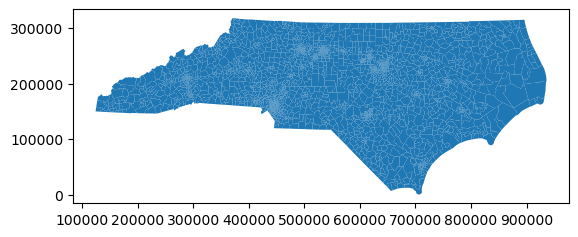

In [44]:
frag_2019.plot()

In [45]:
## save and reimport file to avoid long run times
#frag_2019.to_file("../../data/derived/public/Intersection_2016_precinct_2019_district.shp")

In [46]:
#frag_2019 = gpd.read_file("../../data/derived/public/Intersection_2016_precinct_2019_district.shp")

Now calculate the area of the fragments and the variables needed for area-weighted reaggregation.

In [47]:
frag_2019 = frag_2019.assign(fArea = frag_2019.geometry.area)

In [48]:
frag_2019 = frag_2019.assign(aw = frag_2019['fArea']/frag_2019['pArea'])

In [49]:
frag_2019 = frag_2019.assign(awDem = frag_2019['aw']*frag_2019['dem'])

In [50]:
frag_2019 = frag_2019.assign(awRep = frag_2019['aw']*frag_2019['rep'])

In [51]:
frag_2019

,PREC_ID,ENR_DESC,COUNTY_NAM,COUNTY_ID,dem,rep,cntyprec,pArea,pctRep,DISTRICT,POPULATION,geometry,fArea,aw,awDem,awRep
0,06N,06N_NORTH GRAHAM,ALAMANCE,1,834,423,ALAMANCE 06N,4.295296e+06,0.336516,13,733498,"POLYGON ((574565.642 259472.906, 574566.725 25...",4.295296e+06,1.000000e+00,8.340000e+02,423.000000
1,1210,1210_BURLINGTON 10,ALAMANCE,1,607,569,ALAMANCE 1210,3.105714e+06,0.483844,13,733498,"POLYGON ((568506.748 256892.610, 568492.331 25...",3.105714e+06,1.000000e+00,6.070000e+02,569.000000
2,06E,06E_EAST GRAHAM,ALAMANCE,1,741,671,ALAMANCE 06E,6.182702e+06,0.475212,13,733498,"POLYGON ((574717.887 258121.275, 574748.910 25...",6.182702e+06,1.000000e+00,7.410000e+02,671.000000
3,063,063_GRAHAM 3,ALAMANCE,1,996,528,ALAMANCE 063,5.727881e+06,0.346457,13,733498,"POLYGON ((574414.625 259454.303, 574195.021 25...",5.727881e+06,1.000000e+00,9.960000e+02,528.000000
4,12N,12N_NORTH BURLINGTON,ALAMANCE,1,1777,289,ALAMANCE 12N,7.176965e+06,0.139884,13,733498,"POLYGON ((570632.385 260324.377, 570550.593 26...",7.176965e+06,1.000000e+00,1.777000e+03,289.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3366,DV2-B,DV2-B_DAVIDSON #2-B,IREDELL,49,1014,2162,IREDELL DV2-B,2.550414e+07,0.680730,12,733499,"MULTIPOLYGON (((443296.864 196711.421, 443273....",8.952957e-02,3.510394e-09,3.559540e-06,0.000008
3367,CC4,CC4_CODDLE CREEK #4,IREDELL,49,1354,2818,IREDELL CC4,3.089209e+07,0.675455,12,733499,"MULTIPOLYGON (((446834.346 196385.916, 446773....",1.675617e-02,5.424097e-10,7.344228e-07,0.000002
3368,236,236,MECKLENBURG,60,920,1986,MECKLENBURG 236,3.547930e+07,0.683414,12,733499,"POLYGON ((467893.501 163261.753, 467898.585 16...",3.547930e+07,1.000000e+00,9.200000e+02,1985.999995
3369,221,221,MECKLENBURG,60,970,1973,MECKLENBURG 221,2.412861e+07,0.670404,12,733499,"POLYGON ((461177.186 159661.887, 461186.318 15...",2.412861e+07,1.000000e+00,9.700000e+02,1972.999996


**Unplanned deviation from analysis:** before conducting the group by, the attribute table has to be separated from the geometry. In the original plan, the attribute separation occurs immediately following the group by.

In [52]:
grouped_districts_2019 = frag_2019.drop(columns = "geometry")

In [54]:
grouped_districts_2019 = grouped_districts_2019.groupby(['DISTRICT']).sum()

In [55]:
grouped_districts_2019

,PREC_ID,ENR_DESC,COUNTY_NAM,COUNTY_ID,dem,rep,cntyprec,pArea,pctRep,POPULATION,fArea,aw,awDem,awRep
DISTRICT,,,,,,,,,,,,,,
1,C1MHW2W1M2M1SNWHWDRXIWC2OLDFTCRKCHOCOWASH2PANT...,C1_COLERAIN 1MH_MERRY HILLW2_WINDSOR 2W1_WINDS...,BERTIEBERTIEBERTIEBERTIEBERTIEBERTIEBERTIEBERT...,19506,83923,86100,BERTIE C1BERTIE MHBERTIE W2BERTIE W1BERTIE M2B...,2.445523e+10,155.323036,228851376,1.816830e+10,253.216972,67101.353607,58818.920556
10,0104G1G2MS1S2T1T4T5W27032423160225384034081328...,01_CHERRY LANE04_GLADE CREEKG1G2- GWALTNEY #1 ...,ALLEGHANYALLEGHANYALEXANDERALEXANDERALEXANDERA...,13836,138860,279256,ALLEGHANY 01ALLEGHANY 04ALEXANDER G1G2ALEXANDE...,1.254229e+10,189.104579,200978726,8.867356e+09,190.188822,88088.561032,197713.344880
11,12010302050918191004170608141316150711STECWEST...,12_MINNEAPOLIS01_ALTAMONT03_BEECH MOUNTAIN02_B...,AVERYAVERYAVERYAVERYAVERYAVERYAVERYAVERYAVERYA...,13261,91980,178213,AVERY 12AVERY 01AVERY 03AVERY 02AVERY 05AVERY ...,1.887000e+10,209.511195,234719680,1.736744e+10,304.299438,87813.929030,167624.994506
12,01-0401-0601-0210-002429454203-0002-0301-09272...,01-0401-0601-0210-0024_BELMONT #229_NEW HOPE45...,CABARRUSCABARRUSCABARRUSCABARRUSGASTONGASTONGA...,10785,251672,134245,CABARRUS 01-04CABARRUS 01-06CABARRUS 01-02CABA...,1.935297e+09,64.903746,137897812,1.214355e+09,150.269364,228179.803227,97802.316208
13,06N121006E06312N1251110S06412809S12S09N06W12E1...,06N_NORTH GRAHAM1210_BURLINGTON 1006E_EAST GRA...,ALAMANCEALAMANCEALAMANCEALAMANCEALAMANCEALAMAN...,11319,129570,278390,ALAMANCE 06NALAMANCE 1210ALAMANCE 06EALAMANCE ...,1.512084e+10,175.462791,192176476,9.733017e+09,186.313365,98402.599710,218713.005215
2,3332PR083101-1201-1301-1401-1501-1601-1701-180...,33_LOWES GROVE BAPTIST32_NEAL MIDDLE SCHOOLPR0...,DURHAMDURHAMHARNETTDURHAMWAKEWAKEWAKEWAKEWAKEW...,17239,90945,81404,DURHAM 33DURHAM 32HARNETT PR08DURHAM 31WAKE 01...,2.854056e+09,90.509208,144499303,1.494264e+09,165.964742,80208.726604,66650.489565
3,RVRDAURORNCRKC1MHWHWASH1BLCKOLDFBELHVGILEATCRK...,RVRD_RIVER ROADAUROR_AURORANCRK_NORTH CREEKC1_...,BEAUFORTBEAUFORTBEAUFORTBERTIEBERTIEBERTIEBEAU...,12543,75210,127480,BEAUFORT RVRDBEAUFORT AURORBEAUFORT NCRKBERTIE...,3.609825e+10,178.225870,205379720,3.030851e+10,234.310475,64594.301722,112188.322849
4,1110S09S334718524806070813100517022605293230-2...,11_PLEASANT GROVE10S_SOUTH MELVILLE09S_SOUTH T...,ALAMANCEALAMANCEALAMANCEDURHAMDURHAMDURHAMDURH...,13964,109450,107299,ALAMANCE 11ALAMANCE 10SALAMANCE 09SDURHAM 33DU...,1.076494e+10,106.508885,180440754,6.428145e+09,182.280082,74912.524839,66849.004656
5,010406A03A01030204B1B2EG1G2LRSLMS1S2T1T4T51611...,01_CHERRY LANE04_GLADE CREEK06A_PRATHERS CREEK...,ALLEGHANYALLEGHANYALLEGHANYALLEGHANYAVERYAVERY...,11124,82746,188037,ALLEGHANY 01ALLEGHANY 04ALLEGHANY 06AALLEGHANY...,1.372874e+10,192.330982,196577732,1.069145e+10,213.849822,55309.282645,137961.097082


#### Process district wide data for 2019

Now, merge the area-weighted reaggregation of votes with the 2019 congressional district geometry.
**Unplanned deviation from analysis plan** pctDRep must be multiplied by 100 to output a percent rather than a proportion.

In [57]:
D_awr_2019 = cd_2019.merge(grouped_districts_2019, on = 'DISTRICT')

In [58]:
D_awr_2019.head()

,DISTRICT,POPULATION_x,geometry,PREC_ID,ENR_DESC,COUNTY_NAM,COUNTY_ID,dem,rep,cntyprec,pArea,pctRep,POPULATION_y,fArea,aw,awDem,awRep
0,12,733499,"POLYGON ((449362.059 184483.802, 449368.426 18...",01-0401-0601-0210-002429454203-0002-0301-09272...,01-0401-0601-0210-0024_BELMONT #229_NEW HOPE45...,CABARRUSCABARRUSCABARRUSCABARRUSGASTONGASTONGA...,10785,251672,134245,CABARRUS 01-04CABARRUS 01-06CABARRUS 01-02CABA...,1.935297e+09,64.903746,137897812,1.214355e+09,150.269364,228179.803227,97802.316208
1,2,733499,"POLYGON ((622633.549 201431.242, 622384.873 20...",3332PR083101-1201-1301-1401-1501-1601-1701-180...,33_LOWES GROVE BAPTIST32_NEAL MIDDLE SCHOOLPR0...,DURHAMDURHAMHARNETTDURHAMWAKEWAKEWAKEWAKEWAKEW...,17239,90945,81404,DURHAM 33DURHAM 32HARNETT PR08DURHAM 31WAKE 01...,2.854056e+09,90.509208,144499303,1.494264e+09,165.964742,80208.726604,66650.489565
2,3,733499,"POLYGON ((773148.847 217156.853, 773146.315 21...",RVRDAURORNCRKC1MHWHWASH1BLCKOLDFBELHVGILEATCRK...,RVRD_RIVER ROADAUROR_AURORANCRK_NORTH CREEKC1_...,BEAUFORTBEAUFORTBEAUFORTBERTIEBERTIEBERTIEBEAU...,12543,75210,127480,BEAUFORT RVRDBEAUFORT AURORBEAUFORT NCRKBERTIE...,3.609825e+10,178.225870,205379720,3.030851e+10,234.310475,64594.301722,112188.322849
3,1,733498,"POLYGON ((747975.917 187057.151, 747789.630 18...",C1MHW2W1M2M1SNWHWDRXIWC2OLDFTCRKCHOCOWASH2PANT...,C1_COLERAIN 1MH_MERRY HILLW2_WINDSOR 2W1_WINDS...,BERTIEBERTIEBERTIEBERTIEBERTIEBERTIEBERTIEBERT...,19506,83923,86100,BERTIE C1BERTIE MHBERTIE W2BERTIE W1BERTIE M2B...,2.445523e+10,155.323036,228851376,1.816830e+10,253.216972,67101.353607,58818.920556
4,4,733499,"POLYGON ((570678.318 223963.120, 570684.661 22...",1110S09S334718524806070813100517022605293230-2...,11_PLEASANT GROVE10S_SOUTH MELVILLE09S_SOUTH T...,ALAMANCEALAMANCEALAMANCEDURHAMDURHAMDURHAMDURH...,13964,109450,107299,ALAMANCE 11ALAMANCE 10SALAMANCE 09SDURHAM 33DU...,1.076494e+10,106.508885,180440754,6.428145e+09,182.280082,74912.524839,66849.004656


Calculate voting percentages and compactness scores at the district level.

In [59]:
D_awr_2019 = D_awr_2019.assign(pctDRep = D_awr_2019['awRep']/(D_awr_2019['awDem']+D_awr_2019['awRep'])*100)

In [60]:
D_awr_2019 = D_awr_2019.assign(dPerim = D_awr_2019.geometry.length)

In [61]:
D_awr_2019 = D_awr_2019.assign(dArea = D_awr_2019.geometry.area)

In [62]:
D_awr_2019 = D_awr_2019.assign(dCompact = 400*math.pi*D_awr_2019['dArea']/D_awr_2019['dPerim']** 2)

**Unplanned deviation from analysis plan:** Drop irrelevant columns before saving. Due to the geometric transformations occuring throught the analysis, the columns dropped below have lost their meaning and therefore only add clutter.

In [63]:
D_awr_2019 = D_awr_2019.drop(["PREC_ID", "ENR_DESC", "COUNTY_NAM", "COUNTY_ID", "dem", "rep", "cntyprec", "pArea", "pctRep", "fArea", "aw"], axis = 1)

In [64]:
# save to file
frag_2019.to_file("../../results/other/D_awr_2019.shp")

#### Generate Summary Statistics for 2019 Districts
Append the 2019 summary stats to the existing.. this section eeds work

In [65]:
ss_2019 = {
    '2019 pct rep': [D_awr_2019['pctDRep'].min(), D_awr_2019['pctDRep'].mean(), D_awr_2019['pctDRep'].max()],
    '2019 compactness':  [D_awr_2019['dCompact'].min(), D_awr_2019['dCompact'].mean(), D_awr_2019['dCompact'].max()]
}

In [66]:
summary_stats.loc[len(summary_stats)]=ss_2019

In [68]:
summary_stats

,2016 pct rep,2016 compactness
min,28.923864,15.374277
mean,55.032041,24.886394
max,67.610169,37.100314
3,NaN,NaN


### Analysis

Describe the methods of analysis that will directly test the hypotheses or provide results to answer the research questions.
This section should explicitly define any spatial / statistical *models* and their *parameters*, including *grouping* criteria, *weighting* criteria, and *significance thresholds*.
Also explain any follow-up analyses or validations.



## Results

Describe how results are to be presented.



## Discussion

Describe how the results are to be interpreted *vis a vis* each hypothesis or research question.



## Integrity Statement

Include an integrity statement - The authors of this preregistration state that they completed this preregistration to the best of their knowledge and that no other preregistration exists pertaining to the same hypotheses and research.
If a prior registration *does* exist, explain the rationale for revising the registration here.



# Acknowledgements

- `Funding Name`: name of funding for the project
- `Funding Title`: title of project grant
- `Award info URI`: web address for award information
- `Award number`: award number

This report is based upon the template for Reproducible and Replicable Research in Human-Environment and Geographical Sciences, DOI:[10.17605/OSF.IO/W29MQ](https://doi.org/10.17605/OSF.IO/W29MQ)

## References